1. The data are split in two files, load the files and merge them
according to the first column, which is the index; both the files
contain a "class" column, keep both the columns in the merged
file calling them "class_x" and "class_y" (you can use the merge
function of pandas dataframes)
(4pt)
2. Delete all the rows where class_x is different from class_y, then
drop class_y and rename class_x as class
(4pt)
3. Reorder the columns in alphabetical order, but placing the class
column as the last one; the cleaned dataframe must be named
df; show its size and head
(4pt)
4. Find the best classification scheme using three classification
methods
5. For each classification method find the best parameter setting
with cross validation on the training set
(6pt)
6. For each classification method compute the accuracy and the
confusion matrix on the test set
(4pt)
7. Produce a plot of the accuracies given by the methods
attempted
(3pt)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

random_state = 42
np.random.seed(random_state)
%matplotlib inline

filename1 = './datasets/exam_1.csv'
filename2 = './datasets/exam_2.csv'
separator = ','

# 1

In [2]:
df1 = pd.read_csv(filename1, sep=separator)
df2 = pd.read_csv(filename2, sep=separator)

df1.columns = ['id', *list(df1.columns[1:])]
df2.columns = ['id', *list(df1.columns[1:])]

In [3]:
df = df1.merge(df2, suffixes=('_x', '_y'), left_index=True, right_index=True)

# 2

In [4]:
to_del = df[df['class_x'] != df['class_y']].index
df.drop(to_del, inplace=True, axis=0)
df.drop('class_y', axis=1, inplace=True)
df.rename(columns={'class_x': 'class'}, inplace=True)

# 3

In [5]:
target = 'class'
col_names = list(df.columns)
col_names.remove(target)
col_names.sort()
col_names.append(target)

df = df[col_names]
print(f'Dataset with {df.shape[0]} rows and {df.shape[1]} columns.')
print(f'Dataset size: {df.size}')
df.head()

Dataset with 1984 rows and 9 columns.
Dataset size: 17856


,A_x,A_y,C_x,C_y,E_x,E_y,id_x,id_y,class
0,-0.386248,-1.432057,1.536628,1.039420,1.232589,0.280469,0,0,1
1,-2.686649,-4.036329,4.640702,0.526320,0.823433,-0.419013,1,1,1
2,0.474124,0.179770,1.576616,0.157974,-1.256234,-0.162869,2,2,0
3,-1.343790,-1.299109,-0.514008,-0.152250,1.520392,0.045123,3,3,2
4,-2.187600,-2.089699,0.289041,-0.494995,1.318321,-0.661858,4,4,2


# 4

In [6]:
X = df.drop(target, axis=1)
y = df[target]

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state)

DecisionTree

In [8]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=random_state)
dt.fit(X_train, y_train)
dt_pred_train = dt.predict(X_train)
dt_pred_test = dt.predict(X_test)

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
dt_train_acc = accuracy_score(y_train, dt_pred_train)*100
dt_test_acc = accuracy_score(y_test, dt_pred_test)*100

LinearPerceptron

In [9]:
from sklearn.linear_model import Perceptron

lp = Perceptron(random_state=random_state)
lp.fit(X_train, y_train)
lp_pred_train = lp.predict(X_train)
lp_pred_test = lp.predict(X_test)

lp_train_acc = accuracy_score(y_train, lp_pred_train)*100
lp_test_acc = accuracy_score(y_test, lp_pred_test)*100


K-nearest Neighbors

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
knn_pred_train = knn.predict(X_train)
knn_pred_test = knn.predict(X_test)

knn_train_acc = accuracy_score(y_train, knn_pred_train)*100
knn_test_acc = accuracy_score(y_test, knn_pred_test)*100


In [11]:
result = pd.DataFrame({
    'Decision Tree': [dt_train_acc, dt_test_acc],
    'Perceptron': [lp_train_acc, lp_test_acc],
    'KNN': [knn_train_acc, knn_test_acc]
}, index=['Train', 'Test'])

result

,Decision Tree,Perceptron,KNN
Train,100.000000,35.080645,58.198925
Test,81.854839,30.846774,35.887097


# 5

In [12]:
model_lbls = ['dt', 'lp', 'knn']
score = 'precision'

tuned_params_dt = [
    {'max_depth': list(range(1, dt.get_depth()+1)), 'random_state': [random_state]}
]
tuned_params_lp = [
    {'early_stopping': [True], 'random_state': [random_state]}
]
tuned_params_knn = [
    {'n_neighbors': list(range(1, 10))}
]

models = {
    'dt': {
        'name' : 'Decision Tree',
        'model': DecisionTreeClassifier(),
        'params': tuned_params_dt
    },
    'lp': {
        'name' : 'Perceptron',
        'model': Perceptron(),
        'params': tuned_params_lp
    },
    'knn': {
        'name' : 'KNN',
        'model': KNeighborsClassifier(),
        'params': tuned_params_knn
    }
}

In [13]:
def print_results(model):
    print("Best parameters set found on train set:")
    print()
    # if best is linear there is no gamma parameter
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, std, params_tuple in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params_tuple))
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    print()
    y_true, y_pred = y_test, model.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

In [14]:
result_short = {}
best_params = {}

from sklearn.model_selection import GridSearchCV

for m in model_lbls:
    print('='*80)
    print(f'Grid search for {models[m]["name"]}')
    clf = GridSearchCV(models[m]['model'], models[m]['params'], cv=5, scoring='%s_macro'%score)
    clf.fit(X_train, y_train)
    print_results(clf)
    result_short[m] = clf.best_score_
    best_params[m] = clf.best_params_

for m in result_short.keys():
    print("{}\t - score: {:5.2f}%".format(models[m]['name'], result_short[m]*100))

print(best_params)


Grid search for Decision Tree
Best parameters set found on train set:

{'max_depth': 6, 'random_state': 42}

Grid scores on train set:

0.432 (+/-0.022) for {'max_depth': 1, 'random_state': 42}
0.814 (+/-0.040) for {'max_depth': 2, 'random_state': 42}
0.814 (+/-0.043) for {'max_depth': 3, 'random_state': 42}
0.828 (+/-0.039) for {'max_depth': 4, 'random_state': 42}
0.824 (+/-0.051) for {'max_depth': 5, 'random_state': 42}
0.835 (+/-0.053) for {'max_depth': 6, 'random_state': 42}
0.834 (+/-0.050) for {'max_depth': 7, 'random_state': 42}
0.832 (+/-0.036) for {'max_depth': 8, 'random_state': 42}
0.821 (+/-0.045) for {'max_depth': 9, 'random_state': 42}
0.820 (+/-0.042) for {'max_depth': 10, 'random_state': 42}
0.825 (+/-0.032) for {'max_depth': 11, 'random_state': 42}
0.825 (+/-0.044) for {'max_depth': 12, 'random_state': 42}
0.820 (+/-0.049) for {'max_depth': 13, 'random_state': 42}
0.818 (+/-0.049) for {'max_depth': 14, 'random_state': 42}
0.820 (+/-0.044) for {'max_depth': 15, 'random_

# 6

In [15]:
dt = DecisionTreeClassifier(max_depth=best_params['dt']['max_depth'], random_state=random_state)
lp = Perceptron(early_stopping=best_params['lp']['early_stopping'], random_state=random_state)
knn = KNeighborsClassifier(n_neighbors=best_params['knn']['n_neighbors'])

In [16]:
dt.fit(X_train, y_train);
lp.fit(X_train, y_train);
knn.fit(X_train, y_train);

In [17]:
dt_pred_test = dt.predict(X_test)
lp_pred_test = lp.predict(X_test)
knn_pred_test = knn.predict(X_test)

dt_test_acc = accuracy_score(y_test, dt_pred_test)*100
lp_test_acc = accuracy_score(y_test, lp_pred_test)*100
knn_test_acc = accuracy_score(y_test, knn_pred_test)*100

In [18]:
result = pd.DataFrame({
    'Decision Tree': [dt_test_acc],
    'Perceptron': [lp_test_acc],
    'KNN': [knn_test_acc]
}, index=['Test'])
result

,Decision Tree,Perceptron,KNN
Test,81.25,34.677419,45.766129


In [20]:
dt_cm = confusion_matrix(y_test, dt_pred_test)
lp_cm = confusion_matrix(y_test, lp_pred_test)
knn_cm = confusion_matrix(y_test, knn_pred_test)

In [22]:
print('Decision Tree')
print(dt_cm)

Decision Tree
[[113  18  21]
 [ 22 134  17]
 [  9   6 156]]


In [23]:
print('Perceptron')
print(lp_cm)

Perceptron
[[  1   0 151]
 [  0   0 173]
 [  0   0 171]]


In [24]:
print('KNN')
print(knn_cm)

KNN
[[68 36 48]
 [61 76 36]
 [54 34 83]]


# 8

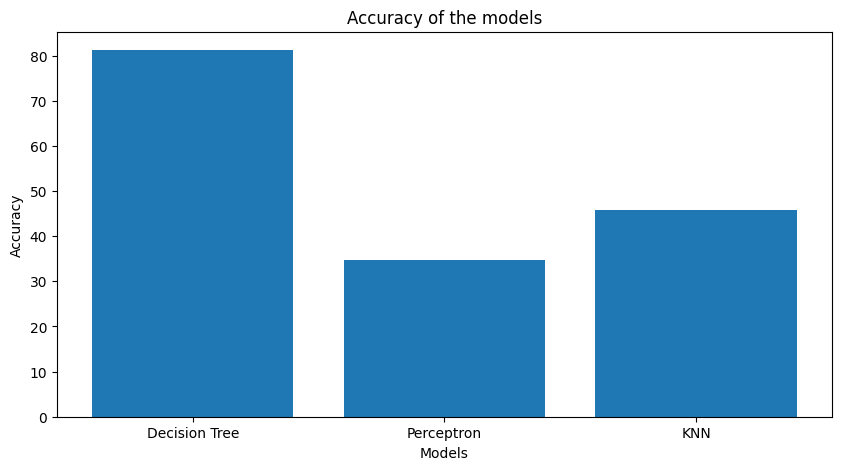

In [25]:
class_list = ['Decision Tree', 'Perceptron', 'KNN']
class_res = [dt_test_acc, lp_test_acc, knn_test_acc]

plt.figure(figsize=(10, 5))
plt.bar(class_list, class_res)
plt.title('Accuracy of the models')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.show()